In [1]:
import gymnasium
import gymnasium.logger
import gymnasium.wrappers.record_video
import numpy as np
import tensorflow
import tensorflow.keras
import tensorflow.keras.layers
import uuid
import typing
import matplotlib.pyplot as plt

In [2]:
def create_environment(name):
    """
    Create an OpenAI Gym environment and set up video recording.

    Parameters:
    - name (str): The name of the OpenAI Gym environment.

    Returns:
    - env (gym.Env): The created OpenAI Gym environment.
    - folder_name (str): The folder path where video recordings will be saved.
    """
    # Generate a unique folder name for video recordings
    folder_name = f"./video/{name}/{uuid.uuid4()}"

    # Create the OpenAI Gym environment with RGB rendering
    env = gymnasium.make(name, render_mode="rgb_array")

    # Wrap the environment to record video with specified folder and disable logger
    env = gymnasium.wrappers.record_video.RecordVideo(env, folder_name, disable_logger=True)

    return env, folder_name

In [3]:
class QTable:
    """
    A simple Q-table-based reinforcement learning agent.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - learning_rate (float): The learning rate for updating Q-values (default is 0.3).
    - discount_factor (float): The discount factor for future rewards in Q-value updates (default is 0.95).
    """
    def __init__(self, action_space: int, state_space: int, learning_rate: float = 0.3, discount_factor: float = 0.95):
        # Initialize the Q-table with random values
        self.q = np.random.random((state_space, action_space))
        self.alpha = learning_rate  # Learning rate for Q-value updates
        self.gamma = discount_factor  # Discount factor for future rewards

    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        """
        Update Q-values based on experienced transitions.

        Parameters:
        - states (List[int]): List of current states.
        - next_states (List[int]): List of next states.
        - actions_taken (List[int]): List of actions taken.
        - rewards (List[float]): List of rewards received.
        """
        for i in range(len(states)):
            # Q-value update using the Q-learning formula
            self.q[states[i]][actions_taken[i]] = self.q[states[i]][actions_taken[i]] + self.alpha * (
                rewards[i] + self.gamma * self.max_reward(next_states[i]) - self.q[states[i]][actions_taken[i]]
            )

    def max_reward(self, state: int) -> float:
        """
        Get the maximum Q-value for a given state.

        Parameters:
        - state (int): The state for which the maximum Q-value is to be obtained.

        Returns:
        - float: The maximum Q-value for the specified state.
        """
        return max(self.qt(state))

    def qt(self, state: int) -> typing.List[float]:
        """
        Get the list of Q-values for all actions in a given state.

        Parameters:
        - state (int): The state for which Q-values are to be obtained.

        Returns:
        - List[float]: The list of Q-values for all actions in the specified state.
        """
        return list(self.q[state])

In [4]:
class QNeural:
    """
    A neural network-based Q-learning agent.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - discount_factor (float): The discount factor for future rewards in Q-value updates (default is 0.95).
    """
    def __init__(self, action_space: int, state_space: int, discount_factor: float = 0.95):
        self.state_space = state_space
        self.action_space = action_space
        self.gamma = discount_factor

        # Define a neural network model using Keras
        self.model = tensorflow.keras.Sequential([
            tensorflow.keras.layers.Input(shape=(state_space,)),
            tensorflow.keras.layers.Dense(512, activation="relu"),
            tensorflow.keras.layers.Dense(action_space, activation="linear"),
        ])
        self.model.compile(loss='mse', optimizer=tensorflow.keras.optimizers.legacy.Adam())

    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        """
        Update the neural network's weights based on experienced transitions.

        Parameters:
        - states (List[int]): List of current states.
        - next_states (List[int]): List of next states.
        - actions_taken (List[int]): List of actions taken.
        - rewards (List[float]): List of rewards received.
        """
        state_one_hot = tensorflow.one_hot(states, self.state_space)
        state_next_one_hot = tensorflow.one_hot(next_states, self.state_space)
        masks = tensorflow.one_hot(actions_taken, self.action_space)

        # Compute target Q-values for the next states
        target = self.model.predict(state_next_one_hot, verbose=0)
        updated_q_values = rewards + self.gamma * tensorflow.reduce_max(target, axis=1)

        # Compute Q-values for the current states and selected actions
        q_values = self.model.predict(state_one_hot, verbose=0)
        q_action = tensorflow.reduce_sum(tensorflow.multiply(q_values, masks), axis=1)

        # Update the model's weights using Q-learning loss
        self.model.fit(state_one_hot, q_action, epochs=1, verbose=0)

    def qt(self, state: int) -> int:
        """
        Get the action with the highest Q-value for a given state.

        Parameters:
        - state (int): The state for which the action with the highest Q-value is to be obtained.

        Returns:
        - int: The selected action.
        """
        state_tensor = tensorflow.one_hot(state, self.state_space)
        state_tensor = tensorflow.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        action = tensorflow.argmax(action_probs[0]).numpy()
        return action

In [5]:
class EpsilonGreedy:
    """
    An epsilon-greedy exploration strategy for action selection.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - epsilon_decay (float): The rate at which the exploration probability epsilon decays (default is 0.99).
    """
    def __init__(self, action_space: int, state_space: int, epsilon_decay: float = 0.99):
        self.epsilon = 1  # Initial exploration probability
        self.epsilon_decay = epsilon_decay  # Rate at which epsilon decays
        self.action_space = action_space  # Number of possible actions
        self.state_space = state_space  # Number of possible states

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using epsilon-greedy strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        n = np.random.rand()  # Random number from a uniform distribution [0, 1)

        if n < self.epsilon:
            action = np.random.randint(0, self.action_space)  # Random exploration
        else:
            action = max(q, key=lambda a: a[1])[0]  # Exploitation, choose action with highest Q-value
            
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay  # Decay epsilon over time

        return action

In [6]:
class UpperConfidenceBound:
    """
    An Upper Confidence Bound (UCB) exploration strategy for action selection.

    Parameters:
    - action_space (int): The number of possible actions in the environment.
    - state_space (int): The number of possible states in the environment.
    - p_decay (float): The parameter controlling the exploration-exploitation balance (default is 4.0).
    """
    def __init__(self, action_space: int, state_space: int, p_decay: float = 4.0):
        self.p_decay = p_decay  # Parameter controlling exploration-exploitation balance
        self.t = 1  # Time step
        self.action_space = action_space  # Number of possible actions
        self.state_space = state_space  # Number of possible states
        self.count_selected = np.ones((state_space, action_space))  # Count of selections for each action

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        """
        Select the next action using the Upper Confidence Bound (UCB) strategy.

        Parameters:
        - q (List[Tuple[int, float]]): List of tuples containing actions and their associated Q-values.
        - state (int): The current state.

        Returns:
        - int: The selected action.
        """
        ut = np.sqrt((self.p_decay * np.log(self.t)) / np.array(self.count_selected[state]))  # UCB term
        qt = np.array(q) + ut  # UCB-augmented Q-values

        # Choose the action with the highest UCB-augmented Q-value
        action = max(enumerate(qt), key=lambda n: n[1])[0]

        # Update selection count and time step
        self.count_selected[state][action] += 1
        self.t += 1

        return action

In [7]:
def learn(env, num_episodes: int, selection_method, learning_method):
    """
    Train a reinforcement learning agent using a specified selection method and learning method.

    Parameters:
    - env (gym.Env): The OpenAI Gym environment.
    - num_episodes (int): The number of episodes to run during training.
    - selection_method: An instance of a selection strategy class (e.g., EpsilonGreedy, UpperConfidenceBound).
    - learning_method: An instance of a learning method class (e.g., QTable, QNeural).

    Returns:
    - List[float]: List of mean rewards for each episode during training.
    """
    batch_size = 32
    update_after_actions = 16
    max_steps_per_episode = 1000
    
    # Initialize the learning and selection methods
    l = learning_method(env.action_space.n, env.observation_space.n)
    s = selection_method(env.action_space.n, env.observation_space.n)

    episode_mean_reward = []

    for episode in range(num_episodes):
        round = 0
        rewards_history = []
        action_history = []
        state_history = []
        state_next_history = []

        if episode % 100 == 0:
            print(f"Episode {episode}...")

        observation, state = env.reset()
        done = False

        while not done and round < max_steps_per_episode:
            round += 1
            
            # Select the next action using the chosen selection method
            action = s.next_action(l.qt(observation), observation)

            old_observation = observation
            observation, reward, done, _, state = env.step(action)

            rewards_history.append(reward)
            action_history.append(action)
            state_history.append(old_observation)
            state_next_history.append(old_observation)

            if round % update_after_actions == 0 and len(rewards_history) > batch_size:
                # Sample a batch of experiences for learning
                indices = np.random.choice(range(len(rewards_history)), size=batch_size)
                
                state_sample = [state_history[i] for i in indices]
                state_next_sample = [state_next_history[i] for i in indices]
                action_sample = [action_history[i] for i in indices]
                rewards_sample = [rewards_history[i] for i in indices]
            
                # Update the learning method with the sampled experiences
                l.update(state_sample, state_next_sample, action_sample, rewards_sample)

        episode_mean_reward.append(np.mean(rewards_history))

    env.close()
    return episode_mean_reward

Episode 0...
Episode 100...
Episode 200...
Episode 300...
Episode 400...
Episode 500...
Episode 600...
Episode 700...
Episode 800...
Episode 900...
Episode 1000...
Episode 1100...
Episode 1200...
Episode 1300...
Episode 1400...
Episode 1500...
Episode 1600...
Episode 1700...
Episode 1800...
Episode 1900...
Video in ./video/Taxi-v3/d8a04333-bed9-463b-91b1-0f7baf76718c


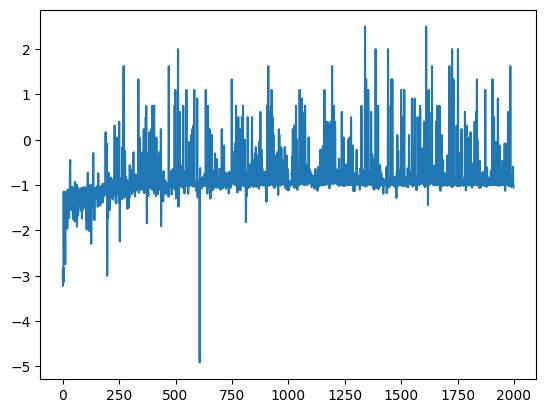

In [8]:
env, folder_name = create_environment("Taxi-v3")
rewards = learn(env, 2000, UpperConfidenceBound, QTable)

print(f"Video in {folder_name}")

plt.plot(rewards)
plt.show()